<a href="https://colab.research.google.com/github/snehasoni26/DLBasedResourceAllocation/blob/new/Copy_of_final7thSemProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile, os

zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/google_cluster_data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Unzipped dataset successfully!")
else:
    print("Dataset already extracted.")

csv_path = "/content/google_cluster_data/borg_traces_data.csv"
df = pd.read_csv(csv_path)


Mounted at /content/drive
Unzipped dataset successfully!


In [ ]:
df = pd.read_csv("/content/google_cluster_data/borg_traces_data.csv")

df['start_time'] = df['start_time'].astype(int)
df['end_time'] = df['end_time'].astype(int)


In [ ]:
BIN_SIZE = 30 * 1_000_000


In [ ]:
print(BIN_SIZE)

30000000


In [ ]:
def expand_row(row):
    bins = np.arange(row.start_time, row.end_time, BIN_SIZE)
    return pd.DataFrame({
        "time_bin": bins,
        "assigned_memory": row.assigned_memory,
        "page_cache_memory": row.page_cache_memory,
        "cycles_per_instruction": row.cycles_per_instruction,
        "memory_accesses_per_instruction": row.memory_accesses_per_instruction
    })

expanded = pd.concat(df.apply(expand_row, axis=1).tolist(), ignore_index=True)
print("Rows after expansion:", len(expanded))


Rows after expansion: 2977658


In [ ]:
agg = expanded.groupby("time_bin").agg({
    "assigned_memory": "sum",
    "page_cache_memory": "sum",
    "cycles_per_instruction": "mean",
    "memory_accesses_per_instruction": "mean"
})



In [ ]:
agg.head()


,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction
time_bin,,,,
300000000,0.031372,0.001003,NaN,NaN
330000000,0.031372,0.001003,NaN,NaN
360000000,0.031372,0.001003,NaN,NaN
390000000,0.031372,0.001003,NaN,NaN
420000000,0.031372,0.001003,NaN,NaN


In [ ]:
agg = agg.reset_index().rename(columns={"time_bin": "time"})
print("Rows after aggregation:", len(agg))


Rows after aggregation: 31428


In [ ]:
agg['assigned_memory'] = agg['assigned_memory'].rolling(2).mean()
agg['page_cache_memory'] = agg['page_cache_memory'].rolling(2).mean()
agg.fillna(0, inplace=True)


Log Transform (handles huge spikes)


In [ ]:
agg['assigned_memory'] = np.log1p(agg['assigned_memory'])
agg['page_cache_memory'] = np.log1p(agg['page_cache_memory'])


<Axes: >

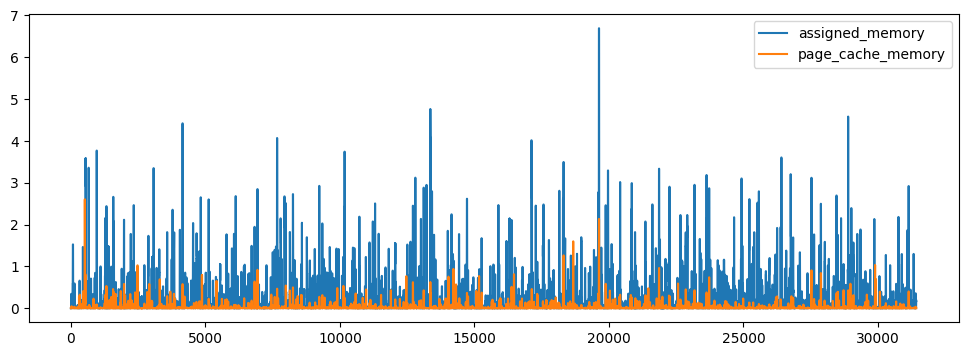

In [ ]:
agg[['assigned_memory','page_cache_memory']].plot(figsize=(12,4))


Scaling

In [ ]:
scaler = MinMaxScaler()
agg_scaled = pd.DataFrame(scaler.fit_transform(agg), columns=agg.columns)

print("Rows after scaling:", len(agg_scaled))


Rows after scaling: 31428


Creating Sequences for LSTM

In [ ]:
target_columns = [
    "assigned_memory",
    "page_cache_memory",
    "cycles_per_instruction",
    "memory_accesses_per_instruction"
]

def create_sequences(data, target_cols, n_steps=30):
    X, y = [], []
    values = data[target_cols].values
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].values)
        y.append(values[i+n_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(agg_scaled, target_columns, n_steps=30)


In [ ]:
print("Rows after sequencing:", len(X))


Rows after sequencing: 31398


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


Build & Train Model

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(len(target_columns))
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - loss: 0.0014 - val_loss: 9.2119e-04 - learning_rate: 0.0010
Epoch 2/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - loss: 6.9451e-04 - val_loss: 7.6857e-04 - learning_rate: 0.0010
Epoch 3/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - loss: 6.3539e-04 - val_loss: 7.3037e-04 - learning_rate: 0.0010
Epoch 4/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 79s 71ms/step - loss: 5.7853e-04 - val_loss: 6.8299e-04 - learning_rate: 0.0010
Epoch 5/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - loss: 5.4627e-04 - val_loss: 6.8475e-04 - learning_rate: 0.0010
Epoch 6/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - loss: 5.5033e-04 - val_loss: 6.4158e-04 - learning_rate: 5.0000e-04
Epoch 7/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - loss: 5.3241e-04 - val_loss: 6.2871e-04 - learning_rate: 5.0000e-04
Epoch 8/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - loss: 5.2644e-04 - val_loss: 6.2166e-04 - learning_rate: 5.0000e-04
Epoch 9/50
628/628 ━━━━━━━━━━━━━

In [ ]:
model.save("lstm_model.h5")
joblib.dump(scaler, "agg_scaler.pkl")
json.dump(target_columns, open("target_columns.json", "w"))


In [ ]:
y_pred = model.predict(X_test)


197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [ ]:
results = {}

for i, col in enumerate(target_columns):
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_pred[:, i])

    results[col] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

results


{'assigned_memory': {'MAE': 0.008247728669324368,
  'MSE': 0.0005642998030133853,
  'RMSE': np.float64(0.023754995327580793),
  'R2 Score': 0.8879518778220884},
 'page_cache_memory': {'MAE': 0.0035525549427211666,
  'MSE': 8.375930461635198e-05,
  'RMSE': np.float64(0.00915201096023994),
  'R2 Score': 0.9228306648226815},
 'cycles_per_instruction': {'MAE': 0.00464453461094583,
  'MSE': 5.2762379935600146e-05,
  'RMSE': np.float64(0.00726377174308225),
  'R2 Score': 0.663138142312443},
 'memory_accesses_per_instruction': {'MAE': 0.026378576259722418,
  'MSE': 0.0028820267646620166,
  'RMSE': np.float64(0.053684511403774705),
  'R2 Score': 0.7622022519351442}}

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame(results).T
print(metrics_df)


                                      MAE       MSE      RMSE  R2 Score
assigned_memory                  0.008248  0.000564  0.023755  0.887952
page_cache_memory                0.003553  0.000084  0.009152  0.922831
cycles_per_instruction           0.004645  0.000053  0.007264  0.663138
memory_accesses_per_instruction  0.026379  0.002882  0.053685  0.762202


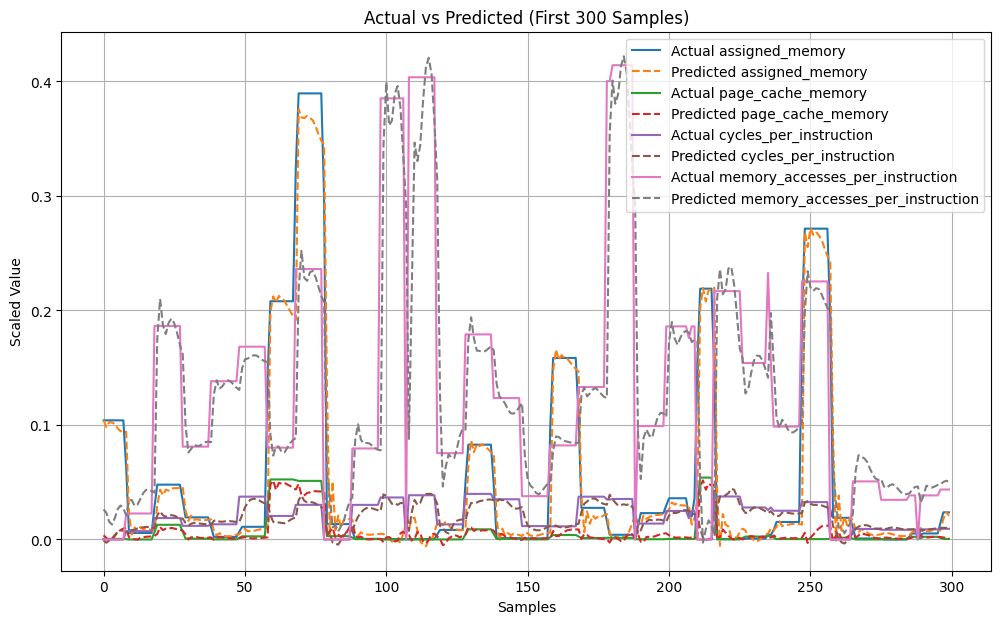

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

for i, col in enumerate(target_columns):
    plt.plot(y_test[:300, i], label=f"Actual {col}")
    plt.plot(y_pred[:300, i], label=f"Predicted {col}", linestyle='dashed')

plt.title("Actual vs Predicted (First 300 Samples)")
plt.xlabel("Samples")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


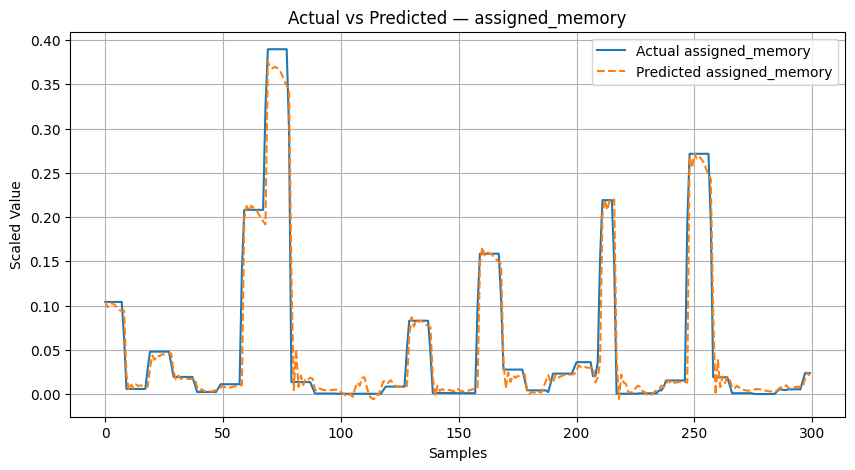

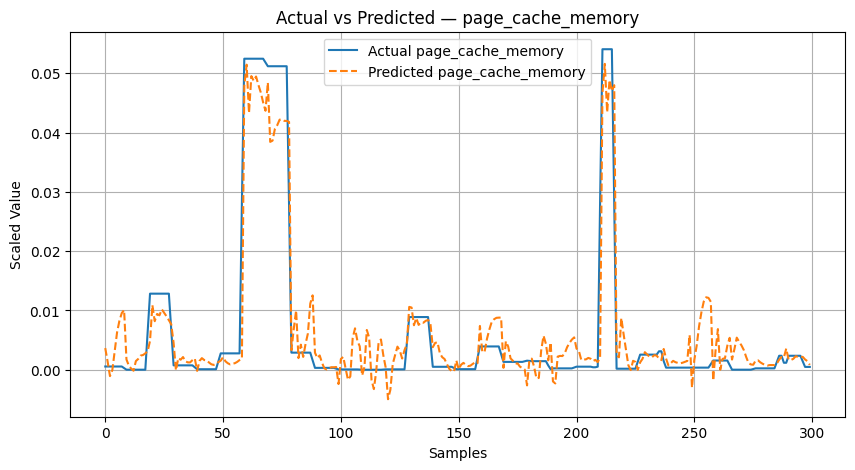

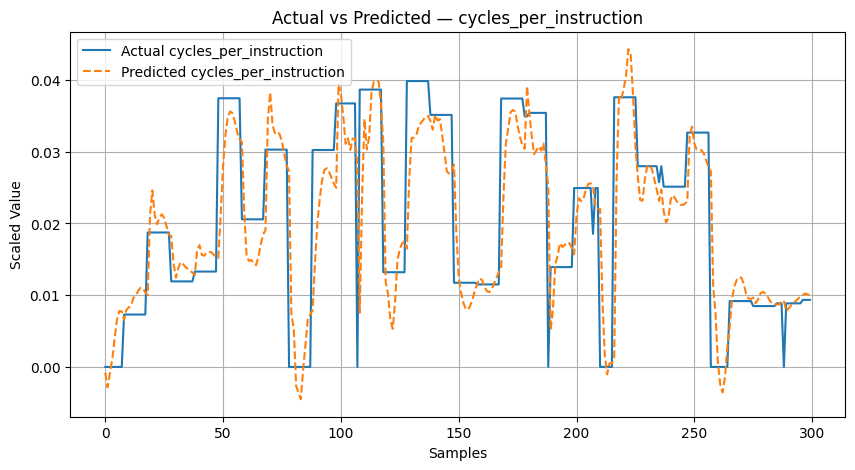

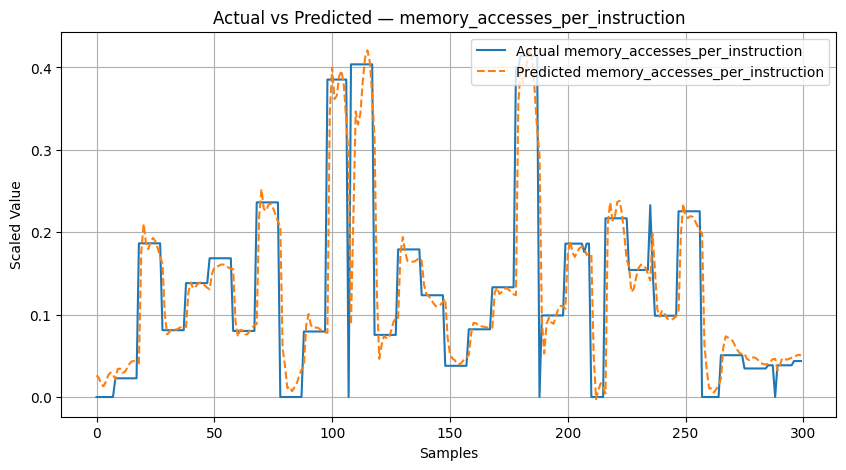

In [ ]:
import matplotlib.pyplot as plt

for i, col in enumerate(target_columns):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[:300, i], label=f"Actual {col}")
    plt.plot(y_pred[:300, i], label=f"Predicted {col}", linestyle='dashed')

    plt.title(f"Actual vs Predicted — {col}")
    plt.xlabel("Samples")
    plt.ylabel("Scaled Value")
    plt.legend()
    plt.grid(True)
    plt.show()


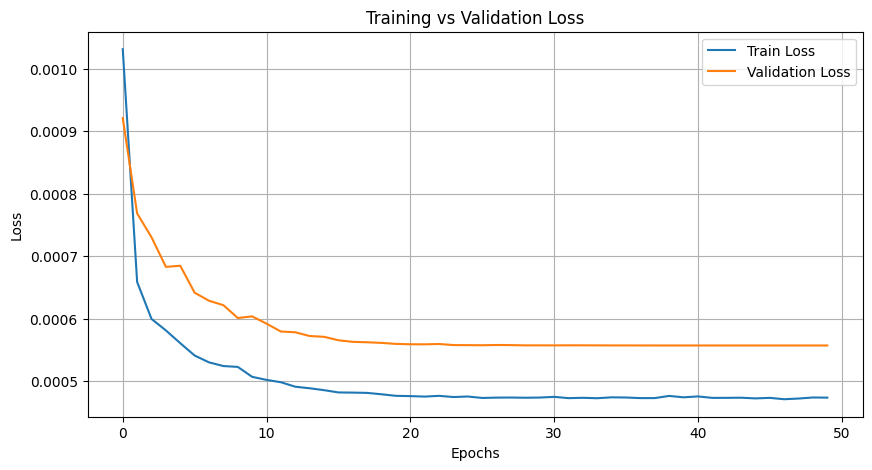

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

np.random.seed(123)
n = 6000

df_task = pd.DataFrame({
    'num_tasks': np.random.randint(1,100,n),
    'avg_task_size': np.random.uniform(0.1,10,n),
    'vm_type': np.random.choice([1,2,3],n),
    'num_users': np.random.randint(1,500,n),
    'time_of_day': np.random.uniform(0,24,n),
    'priority': np.random.randint(1,5,n)
})

df_task['CPU'] = np.clip(
    0.6*(df_task.num_tasks/100) +
    0.3*(df_task.avg_task_size/10) +
    np.random.normal(0,0.03,n),
    0,1
)

df_task['Memory'] = np.clip(
    0.4*(df_task.avg_task_size/10) +
    0.35*(df_task.num_tasks/100) +
    np.random.normal(0,0.03,n),
    0,1
)

df_task['Disk'] = np.clip(
    50*(df_task.avg_task_size/10)+np.random.normal(0,2,n),
    0,100
)

df_task['Network'] = np.clip(
    30*(df_task.num_users/500)+np.random.normal(0,1,n),
    0,100
)

X = df_task[['num_tasks','avg_task_size','vm_type','num_users','time_of_day','priority']]
y = df_task[['CPU','Memory','Disk','Network']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

sx = StandardScaler()
sy = StandardScaler()

X_train_s = sx.fit_transform(X_train)
X_test_s  = sx.transform(X_test)
y_train_s = sy.fit_transform(y_train)
y_test_s  = sy.transform(y_test)

nn = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4)
])

nn.compile(optimizer='adam', loss='mse')

print("\nTraining NN...")
history = nn.fit(X_train_s, y_train_s, epochs=25, batch_size=64, verbose=1)

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.title("Training Loss (Synthetic NN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

y_pred_s = nn.predict(X_test_s)
y_pred = sy.inverse_transform(y_pred_s)

plt.figure(figsize=(6,6))
plt.scatter(y_test['CPU'][:200], y_pred[:200,0], alpha=0.5)
plt.xlabel("Actual CPU")
plt.ylabel("Predicted CPU")
plt.title("Actual vs Predicted CPU (Synthetic NN)")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
LSTM predicted load %: 2.2310286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Final Decision:
CPU Allocation %: 30.144596
Memory Allocation %: 25.96414


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


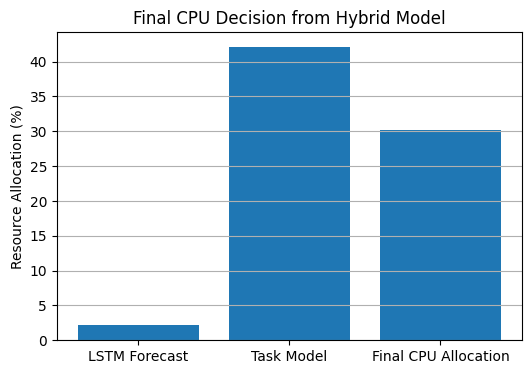

In [ ]:

window = agg_scaled.iloc[-30:].values.reshape(1, 30, agg_scaled.shape[1])

assigned_next = model.predict(window)[0][0]

predicted_load = assigned_next * 100
print("LSTM predicted load %:", predicted_load)

task = np.array([[45, 5.2, 2, 250, 14, 3]])
task_s = sx.transform(task)

task_pred_s = nn.predict(task_s)
task_pred = sy.inverse_transform(task_pred_s)[0]

cpu_task = task_pred[0] * 100
mem_task = task_pred[1] * 100

final_cpu = 0.7 * cpu_task + 0.3 * predicted_load
final_mem = 0.7 * mem_task + 0.3 * predicted_load

print("\nFinal Decision:")
print("CPU Allocation %:", final_cpu)
print("Memory Allocation %:", final_mem)

labels = ["LSTM Forecast", "Task Model", "Final CPU Allocation"]
values = [predicted_load, cpu_task, final_cpu]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Resource Allocation (%)")
plt.title("Final CPU Decision from Hybrid Model")
plt.grid(True, axis='y')
plt.show()
